In [1]:
import pandas as pd 
import numpy as np

#plot
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns


# data preparation and split
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler   

#models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn import neighbors       as nh 


#selection and plot selection
from sklearn import ensemble        as en
from yellowbrick.features import Rank1D

from sklearn import model_selection as ms


#metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, roc_auc_score, confusion_matrix

#cross validation
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV


# Check model calibration
from sklearn.calibration import calibration_curve


#config
import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
def encoder_transform(encoder, df, column):
    df.loc[:, column] =  encoder.transform(df[[column]] )
    return df[[column]] 


In [3]:
def cross_validation(num_folds, model,model_name, X_train, y_train, verbose= True ):
    for j in reversed( range( 1, num_folds+1 ) ):
        if verbose :
            print( '\nKFold Number: {}'.format( j ) )

        kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)

        precision_list = []
        recall_list = []
        f1_score_list = []


        for train_cv,val_cv in kfold.split(X_train, y_train):

            x_train_fold = X_train.iloc[train_cv]
            y_train_fold = y_train.iloc[train_cv]

            x_val_fold = X_train.iloc[val_cv]
            y_val_fold = y_train.iloc[val_cv]

            model_fit = model.fit(x_train_fold,y_train_fold)

            preds = model_fit.predict_proba(x_val_fold)
            preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])
            #Therehold 0.5
            preds_df['pred_loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)
            pd.concat([y_val_fold.reset_index(drop = True), preds_df], axis = 1)

            precision_recall_f1 = precision_recall_fscore_support(y_val_fold,preds_df['pred_loan_status'])
            precision_default = precision_recall_f1[0][1]
            recall_default = precision_recall_f1[1][1]
            f1_default = precision_recall_f1[2][1]


            precision_list.append(precision_default)

            recall_list.append(recall_default)

            f1_score_list.append(f1_default)


    return pd.DataFrame( {'Model Name': model_name,
                          'PRECISION': np.round(np.mean(precision_list), 3).astype(str) + ' +/- ' + np.round(np.std(precision_list), 3).astype(str),
                          'RECALL': np.round( np.mean( recall_list ), 3 ).astype( str ) + ' +/- ' + np.round( np.std( recall_list ), 3 ).astype( str ),
                          'F1_score': np.round( np.mean( f1_score_list ), 3 ).astype( str ) + ' +/- ' + np.round( np.std( f1_score_list ), 3 ).astype( str ) }, index=[0] )




In [51]:
def preds_df_func(model_preds,X_test, y_test, therehold = 0.5):
    

    # Create dataframes of first five predictions, and first five true labels
    preds_df = pd.DataFrame(model_preds[:,1], columns = ['prob_default'])

    # determine Therehold 
    preds_df['pred_loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > therehold else 0)

    pd.concat([y_test.reset_index(drop = True), preds_df], axis = 1)
    
    return preds_df

def economic_impact_nondetected_default(preds_df, y_test,avg_loan_amnt):
    
    # Store the number of loan defaults from the prediction data
    num_defaults = preds_df['pred_loan_status'].value_counts()[1]
    nondef_recalls = preds_df['pred_loan_status'].value_counts()[0]

    # Store the default recall from the classification report
    default_recall = precision_recall_fscore_support(y_test,preds_df['pred_loan_status'])[1][1]

    # Calculate the estimated impact of the new default recall rate
    non_detected_default_impact = round(avg_loan_amnt * num_defaults * (1 - default_recall), 2)
    print('Estimated Loss impact: $', non_detected_default_impact)
    
    return non_detected_default_impact

In [5]:
cr_loan_clean = pd.read_csv('cr_lean_lean.csv')

In [6]:
cr_loan_clean.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


# Data Preparation

In [7]:
#One-hot encoding credit data
# Create two data sets for numeric and non-numeric data
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
cred_str = cr_loan_clean.select_dtypes(include=['object'])


### Transformation

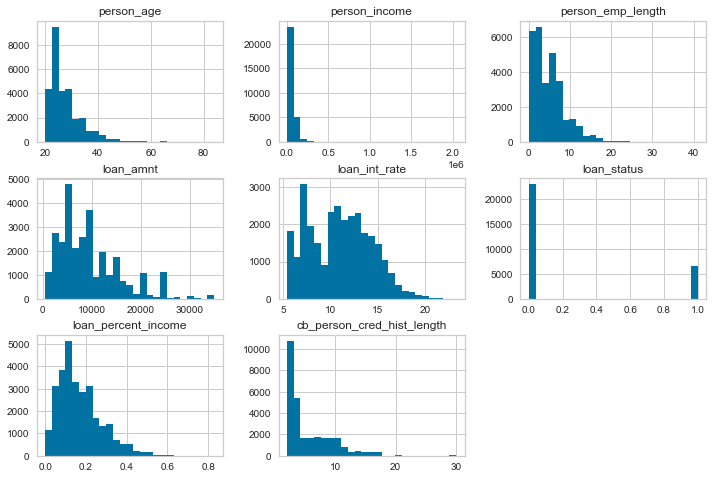

In [8]:
cred_num.hist( bins=25, figsize= (12,8) );

In [9]:
# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)



In [10]:
# Log person_income and loan_amnt
cr_loan_prep['person_income_log'] = np.log1p( cr_loan_prep['person_income'] )
cr_loan_prep['loan_amnt_log'] = np.log1p( cr_loan_prep['loan_amnt']  )



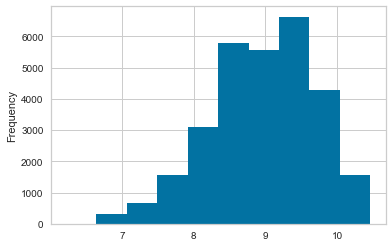

In [11]:
np.log1p( cr_loan_prep['loan_amnt'] ).plot(kind= 'hist');

In [12]:
# Print the columns in the new data set
cr_loan_prep.head(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,person_income_log,loan_amnt_log
0,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,1,0,0,0,0,0,1,0,9.169623,6.908755
1,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,1,0,0,0,0,1,0,9.169623,8.612685


## Split train, test and validation

In [13]:
# Create the X and y data sets
X = cr_loan_prep.drop( 'loan_status', axis=1 )
y = cr_loan_prep[['loan_status']]

# spliting in train, test and validation datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2



In [14]:
print('X_train :{}, {:.2f}%'.format(X_train.shape[0],( X_train.shape[0]/X.shape[0])*100) )
print('X_test :{}, {:.2f}%'.format(X_test.shape[0],( X_test.shape[0]/X.shape[0])*100) )
print('X_validation :{}, {:.2f}%'.format(X_val.shape[0],( X_val.shape[0]/X.shape[0])*100) )


X_train :17675, 60.00%
X_test :5892, 20.00%
X_validation :5892, 20.00%


In [15]:
#concat Train dataset to transformation
cr_loan_train = pd.concat( [X_train, y_train], axis=1 )

In [16]:
#Rescaling MinMaxScaler (non-normal distribuition)
#person_age, person_emp_length, cb_person_cred_hist_length, loan_int_rate
mm_person_age = MinMaxScaler()
mm_person_emp_length = MinMaxScaler()
mm_person_cred_hist_length =MinMaxScaler()
mm_loan_int_rate = MinMaxScaler()



In [17]:
#person_age
X_train['person_age'] = mm_person_age.fit_transform(X_train[['person_age']].values)

#person_emp_length
X_train['person_emp_length'] = mm_person_emp_length.fit_transform(X_train[['person_emp_length']].values)


# cb_person_cred_hist_length
X_train['cb_person_cred_hist_length'] = mm_person_cred_hist_length.fit_transform(X_train[['cb_person_cred_hist_length']].values)

#loan_int_rate
X_train['loan_int_rate'] = mm_loan_int_rate.fit_transform(X_train[['loan_int_rate']].values)



In [18]:
X_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,person_income_log,loan_amnt_log
12185,0.046875,92000,0.048780,15000,0.252247,0.16,0.000000,1,0,0,...,1,0,0,0,0,0,1,0,11.429555,9.615872
24392,0.140625,120000,0.292683,12000,0.293820,0.10,0.250000,1,0,0,...,1,0,0,0,0,0,1,0,11.695255,9.392745
15264,0.046875,96000,0.170732,7300,0.172472,0.08,0.071429,0,0,0,...,0,0,0,0,0,0,1,0,11.472114,8.895767
8518,0.078125,70000,0.097561,8000,0.592135,0.11,0.035714,0,0,0,...,0,1,0,0,0,0,0,1,11.156265,8.987322
10274,0.078125,55016,0.000000,10000,0.434831,0.18,0.000000,0,0,0,...,0,1,0,0,0,0,0,1,10.915398,9.210440


In [19]:
#Test and Validation Preparation
# Test
#person_age, person_emp_length, cb_person_cred_hist_length, loan_int_rate
X_test['person_age'] = encoder_transform(mm_person_age, X_test,'person_age' )
X_test['person_emp_length'] = encoder_transform(mm_person_emp_length, X_test,'person_emp_length' )
X_test['cb_person_cred_hist_length'] = encoder_transform(mm_person_cred_hist_length, X_test,'cb_person_cred_hist_length' )
X_test['loan_int_rate'] = encoder_transform(mm_loan_int_rate, X_test,'loan_int_rate' )


# X_Validation
X_val['person_age'] = encoder_transform(mm_person_age, X_val,'person_age' )
X_val['person_emp_length'] = encoder_transform(mm_person_emp_length, X_val,'person_emp_length' )
X_val['cb_person_cred_hist_length'] = encoder_transform(mm_person_cred_hist_length, X_val,'cb_person_cred_hist_length' )
X_val['loan_int_rate'] = encoder_transform(mm_loan_int_rate, X_val,'loan_int_rate' )




In [20]:
# Inverse Transform
mm_person_age.inverse_transform(X_train[['person_age']])

np.expm1(X_train.person_income_log)

12185     92000.0
24392    120000.0
15264     96000.0
8518      70000.0
10274     55016.0
           ...   
18567     34300.0
21650     67000.0
28348     77000.0
16546    105400.0
13503     48000.0
Name: person_income_log, Length: 17675, dtype: float64

### Feature Importance

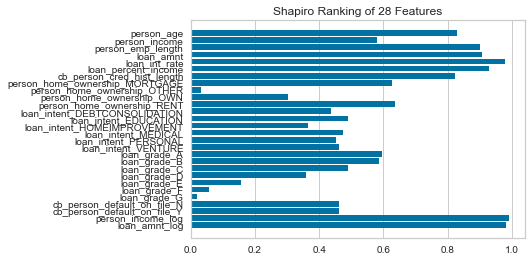

In [21]:
X_train_shapiro = X_train
y_train_shapiro= y_train
#
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(X_train_shapiro, y_train_shapiro)           

visualizer.transform(X_train_shapiro)        
visualizer.show();

In [22]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = X_train.drop(['person_income_log', 'loan_amnt_log'], axis=1)
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

feature ranking
                          feature  importance
0             loan_percent_income    0.213782
0                   person_income    0.106556
0                   loan_int_rate    0.086674
0                       loan_amnt    0.085571
0               person_emp_length    0.074210
0                    loan_grade_D    0.072506
0                      person_age    0.062167
0      cb_person_cred_hist_length    0.053854
0      person_home_ownership_RENT    0.039704
0                    loan_grade_C    0.023368
0   loan_intent_DEBTCONSOLIDATION    0.021996
0                    loan_grade_E    0.021525
0             loan_intent_MEDICAL    0.019585
0  person_home_ownership_MORTGAGE    0.018452
0       person_home_ownership_OWN    0.013085
0                    loan_grade_A    0.012340
0           loan_intent_EDUCATION    0.011271
0     loan_intent_HOMEIMPROVEMENT    0.010499
0     cb_person_default_on_file_N    0.009233
0             loan_intent_VENTURE    0.008886
0            loan_

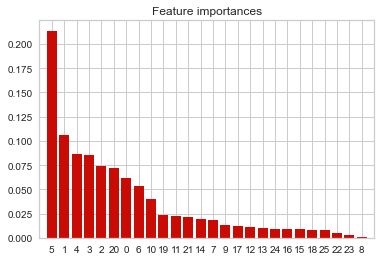

In [23]:
importances = forest.feature_importances_
indices = np.argsort( importances )[::-1]

print( 'feature ranking')
df = pd.DataFrame()

for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [24]:
aux = df.sort_values( 'importance', ascending=False )

sel_columns = aux[aux['importance'] >= 0.02]['feature'].values
aux[aux['importance'] >= 0.02]

,feature,importance
0,loan_percent_income,0.213782
0,person_income,0.106556
0,loan_int_rate,0.086674
0,loan_amnt,0.085571
0,person_emp_length,0.074210
0,loan_grade_D,0.072506
0,person_age,0.062167
0,cb_person_cred_hist_length,0.053854
0,person_home_ownership_RENT,0.039704
0,loan_grade_C,0.023368


# Machine Learning

In [25]:
#remove(['person_income_log', 'loan_amnt_log'])
indices = np.where((sel_columns =='person_income')  | (sel_columns =='loan_amnt'))[0]
sel = np.delete(sel_columns, indices)

a1 =np.append(sel,'person_income_log')
sel_columns_require_normalization = np.append(a1,'person_income_log')
sel_columns_require_normalization

array(['loan_percent_income', 'loan_int_rate', 'person_emp_length',
       'loan_grade_D', 'person_age', 'cb_person_cred_hist_length',
       'person_home_ownership_RENT', 'loan_grade_C',
       'loan_intent_DEBTCONSOLIDATION', 'loan_grade_E',
       'person_income_log', 'person_income_log'], dtype=object)

## Logistic regression

In [26]:
# Create and fit the logistic regression model
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train[sel_columns_require_normalization], np.ravel(y_train))


# Print the parameters of the model
print(clf_logistic.get_params())

# The intercept of the model
print(clf_logistic.intercept_)

# Probablitity to default - coefficients
clf_logistic.coef_

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
[5.61193829]


array([[ 7.1182491 ,  3.39131526,  0.15150959,  1.49391931, -0.37582629,
         0.4228973 ,  0.99809372, -0.31412514,  0.64549977,  1.46639058,
        -0.48414388, -0.48414388]])

In [27]:
preds = clf_logistic.predict_proba(X_test[sel_columns_require_normalization])

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

#Therehold 0.5
preds_df['pred_loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

pd.concat([y_test.reset_index(drop = True), preds_df], axis = 1)

,loan_status,prob_default,pred_loan_status
0,0,0.049436,0
1,1,0.970195,1
2,1,0.395455,0
3,0,0.169721,0
4,1,0.932632,1
...,...,...,...
5887,0,0.080028,0
5888,0,0.012456,0
5889,1,0.909135,1
5890,0,0.069368,0


In [28]:
preds_df['pred_loan_status'].value_counts()

0    4982
1     910
Name: pred_loan_status, dtype: int64

In [29]:
# Check the accuracy against the test data
round(clf_logistic.score(X_test[sel_columns_require_normalization],y_test), 2)

0.86

[[4354  205]
 [ 628  705]]


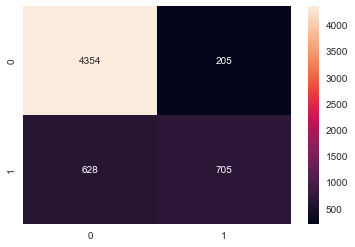

In [30]:
# Print the confusion matrix
print(confusion_matrix(y_test,preds_df['pred_loan_status']))
sns.heatmap(confusion_matrix(y_test,preds_df['pred_loan_status']), annot=True, fmt=".0f");

In [31]:
# Print the classification report
target_names = ['Non-Default', 'Default']

print(classification_report(y_test, preds_df['pred_loan_status'], target_names=target_names) )

              precision    recall  f1-score   support

 Non-Default       0.87      0.96      0.91      4559
     Default       0.77      0.53      0.63      1333

    accuracy                           0.86      5892
   macro avg       0.82      0.74      0.77      5892
weighted avg       0.85      0.86      0.85      5892



In [32]:
# Only Precision, Recall and F1 score
print(precision_recall_fscore_support(y_test,preds_df['pred_loan_status']))

(array([0.87394621, 0.77472527]), array([0.955034  , 0.52888222]), array([0.91269259, 0.62862238]), array([4559, 1333], dtype=int64))


In [33]:
%%timeit
precision_recall_f1 = precision_recall_fscore_support(y_test,preds_df['pred_loan_status'])
precision_default = precision_recall_f1[0][1]
recall_default = precision_recall_f1[1][1]
f1_default = precision_recall_f1[2][1]

1.18 ms ± 18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
%%timeit 
lr_result = cross_validation(3,clf_logistic, 'Logistic Regression', X_train, y_train, False)
lr_result

288 ms ± 44.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
lr_result = cross_validation(3,clf_logistic, 'Logistic Regression', X_train, y_train, False)


In [36]:
def cross_using_scikit(name, model,X_train, y_train,cv=5 ):

    np.random.seed(42)

    precision= np.mean(cross_val_score(model, X_train, y_train,cv= cv ,scoring='precision' )).round(3)
    std_prec = np.std(cross_val_score(model, X_train, y_train,cv= cv ,scoring='precision' )).round(3)

    recall = np.mean(cross_val_score(model, X_train, y_train,cv= cv ,scoring='recall' )).round(3)
    std_recall = np.std(cross_val_score(model, X_train, y_train,cv= cv ,scoring='recall' )).round(3)


    f1 = np.mean(cross_val_score(model, X_train, y_train,cv= cv ,scoring='f1' )).round(3)
    std_f1 = np.std(cross_val_score(model, X_train, y_train,cv= cv ,scoring='f1' )).round(3)

    model_dict = {'name': name, 'PRECISION': precision, '+-_prec': std_prec, 'RECALL': recall, '+-': std_recall, 'F1': f1, '+- f1': std_f1}
    df = pd.DataFrame(model_dict.values()).T
    df.columns = list(model_dict.keys())

    return df



In [37]:
%%timeit
df = cross_using_scikit('logistic', clf_logistic,X_train, y_train)

895 ms ± 68.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
df

,feature,importance
0,person_age,0.062167
0,person_income,0.106556
0,person_emp_length,0.074210
0,loan_amnt,0.085571
0,loan_int_rate,0.086674
0,loan_percent_income,0.213782
0,cb_person_cred_hist_length,0.053854
0,person_home_ownership_MORTGAGE,0.018452
0,person_home_ownership_OTHER,0.001074
0,person_home_ownership_OWN,0.013085


In [39]:
%%timeit

#Evaluating with cross_val_sore from scikit-learning)
np.random.seed(42)
np.mean(cross_val_score(clf_logistic, X_train, y_train,cv=5 ,scoring='precision' ))

np.std(cross_val_score(clf_logistic, X_train, y_train,cv=5 ,scoring='precision' ))

295 ms ± 30.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
np.random.seed(42)

print('average recall cross validation: ',np.mean(cross_val_score(clf_logistic, X_train, y_train,cv=5 ,scoring='recall' )).round(3) )

print('standart deviation: ', round(np.std(cross_val_score(clf_logistic, X_train, y_train,cv=5 ,scoring='recall' )), 3))

average recall cross validation:  0.137
standart deviation:  0.03


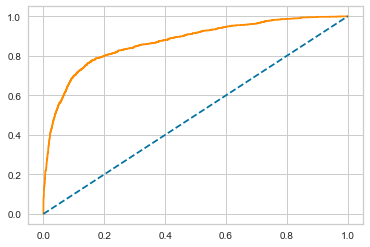

0.8704109016944958

In [41]:
# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
auc

In [42]:
#Average loan amount
avg_loan_amnt = round(cr_loan_prep.loan_amnt.mean(), 2)

# Store the number of loan defaults from the prediction data
num_defaults = preds_df['pred_loan_status'].value_counts()[1]
nondef_recalls = preds_df['pred_loan_status'].value_counts()[0]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,preds_df['pred_loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
lr_default_impact = round(avg_loan_amnt * num_defaults * (1 - default_recall), 2)
print('Estimated Loss impact: $', lr_default_impact)


Estimated Loss impact: $ 4108653.96


## KNN


In [43]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit(X_train[sel_columns_require_normalization], np.ravel(y_train))

KNeighborsClassifier(n_neighbors=7)

In [44]:
preds = knn_model.predict_proba(X_test[sel_columns_require_normalization])

# Create dataframes of first five predictions, and first five true labels
preds_df_knn = pd.DataFrame(preds[:,1], columns = ['prob_default'])

#Therehold 0.5
preds_df_knn['pred_loan_status'] = preds_df_knn['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

pd.concat([y_test.reset_index(drop = True), preds_df_knn], axis = 1)
preds_df_knn.head()

,prob_default,pred_loan_status
0,0.000000,0
1,0.857143,1
2,1.000000,1
3,0.142857,0
4,1.000000,1


[[4386  173]
 [ 540  793]]


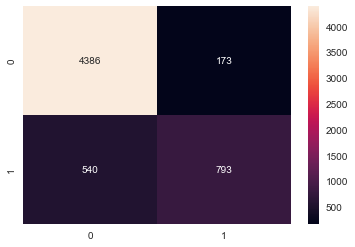

In [45]:
# Print the confusion matrix
print(confusion_matrix(y_test,preds_df_knn['pred_loan_status']))
sns.heatmap(confusion_matrix(y_test,preds_df_knn['pred_loan_status']), annot=True, fmt=".0f");

In [46]:
print(classification_report(y_test, preds_df_knn['pred_loan_status'], target_names=target_names) )


              precision    recall  f1-score   support

 Non-Default       0.89      0.96      0.92      4559
     Default       0.82      0.59      0.69      1333

    accuracy                           0.88      5892
   macro avg       0.86      0.78      0.81      5892
weighted avg       0.87      0.88      0.87      5892



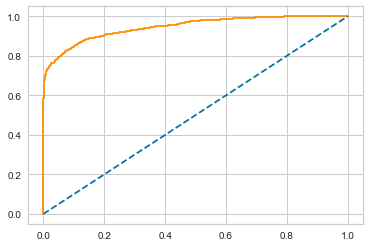

0.9457370374618221

In [87]:
# Plot the ROC curve of the probabilities of default
prob_default_knn = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
auc

In [48]:
knn_result = cross_validation(3,knn_model, 'KNN', X_train, y_train, False)
knn_result

,Model Name,PRECISION,RECALL,F1_score
0,KNN,0.666 +/- 0.009,0.45 +/- 0.006,0.537 +/- 0.004


In [49]:
# Store the number of loan defaults from the prediction data
num_defaults = preds_df_knn['pred_loan_status'].value_counts()[1]
nondef_recalls = preds_df_knn['pred_loan_status'].value_counts()[0]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,preds_df_knn['pred_loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
knn_default_impact = round(avg_loan_amnt * num_defaults * (1 - default_recall), 2)
print('Estimated Loss impact: $', knn_default_impact)


Estimated Loss impact: $ 3750329.41


## XGBOOST

### Column importance and default prediction in XGBoost


In [53]:
# Column importance and default prediction in XGBoost
# Create and train the model on the training data
clf_gbt_all = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# predict
preds_gbt0= clf_gbt_all.predict_proba(X_test)

preds_df_gbt0= preds_df_func(preds_gbt0,X_test, y_test, therehold = 0.5)



# Print the column importances from the model
importance_gbt = clf_gbt_all.get_booster().get_score(importance_type = 'weight')
importance_gbt = sorted(importance_gbt.items() , key=lambda x:x[1], reverse=True) 
importance_gbt

[('person_income', 755.0),
 ('loan_int_rate', 502.0),
 ('loan_amnt', 338.0),
 ('loan_percent_income', 320.0),
 ('person_emp_length', 318.0),
 ('person_age', 285.0),
 ('cb_person_cred_hist_length', 180.0),
 ('loan_intent_MEDICAL', 76.0),
 ('loan_intent_DEBTCONSOLIDATION', 66.0),
 ('person_home_ownership_RENT', 55.0),
 ('loan_grade_C', 54.0),
 ('person_home_ownership_OWN', 52.0),
 ('person_home_ownership_MORTGAGE', 51.0),
 ('loan_grade_D', 51.0),
 ('loan_intent_HOMEIMPROVEMENT', 39.0),
 ('loan_intent_VENTURE', 37.0),
 ('loan_intent_EDUCATION', 36.0),
 ('loan_intent_PERSONAL', 35.0),
 ('loan_grade_B', 31.0),
 ('cb_person_default_on_file_N', 23.0),
 ('loan_grade_E', 17.0),
 ('loan_grade_G', 12.0),
 ('loan_grade_F', 7.0),
 ('person_home_ownership_OTHER', 5.0),
 ('loan_grade_A', 1.0)]

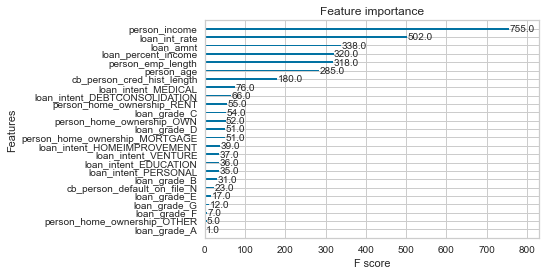

In [54]:
# Plot the column importance for this model
xgb.plot_importance(clf_gbt_all, importance_type = 'weight')
plt.show()

In [55]:
selection_xgt1 = dict(importance_gbt[:14]).keys() 
selection_xgt2 = dict(importance_gbt[:22]).keys() 

selection_xgt2

dict_keys(['person_income', 'loan_int_rate', 'loan_amnt', 'loan_percent_income', 'person_emp_length', 'person_age', 'cb_person_cred_hist_length', 'loan_intent_MEDICAL', 'loan_intent_DEBTCONSOLIDATION', 'person_home_ownership_RENT', 'loan_grade_C', 'person_home_ownership_OWN', 'person_home_ownership_MORTGAGE', 'loan_grade_D', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_VENTURE', 'loan_intent_EDUCATION', 'loan_intent_PERSONAL', 'loan_grade_B', 'cb_person_default_on_file_N', 'loan_grade_E', 'loan_grade_G'])

In [56]:
# Train a model
clf_gbt = xgb.XGBClassifier().fit(X_train[sel_columns], np.ravel(y_train))

# predict
preds_gbt = clf_gbt.predict_proba(X_test[sel_columns])

# df of prediction with therehold
preds_df_gbt= preds_df_func(preds_gbt,X_test[sel_columns], y_test, therehold = 0.5)
preds_df_gbt.head()



,prob_default,pred_loan_status
0,0.040802,0
1,0.992110,1
2,0.980369,1
3,0.036026,0
4,0.992523,1


In [57]:
# Train a model
clf_gbt1 = xgb.XGBClassifier().fit(X_train[selection_xgt1], np.ravel(y_train))

# predict
preds_gbt1 = clf_gbt1.predict_proba(X_test[selection_xgt1])

preds_df_gbt1= preds_df_func(preds_gbt1,X_test[selection_xgt1], y_test, therehold = 0.5)
preds_df_gbt1.head()

,prob_default,pred_loan_status
0,0.041010,0
1,0.996296,1
2,0.995358,1
3,0.015049,0
4,0.999633,1


In [58]:
# Train a model
clf_gbt2= xgb.XGBClassifier().fit(X_train[selection_xgt2], np.ravel(y_train))

# predict
preds_gbt2 = clf_gbt2.predict_proba(X_test[selection_xgt2])

preds_df_gbt2= preds_df_func(preds_gbt2,X_test[selection_xgt2], y_test, therehold = 0.5)
preds_df_gbt2.head()

,prob_default,pred_loan_status
0,0.046210,0
1,0.998865,1
2,0.992869,1
3,0.000289,0
4,0.999871,1


In [59]:

print('all features')
print(classification_report(y_test, preds_df_gbt0['pred_loan_status'], target_names=target_names))

print('firt selection')
print(classification_report(y_test, preds_df_gbt['pred_loan_status'], target_names=target_names))

print('XGbooster selection1')

# Print the classification report of the second model
print(classification_report(y_test, preds_df_gbt1['pred_loan_status'], target_names=target_names))

print('XGbooster selection2')

# Print the classification report of the second model
print(classification_report(y_test, preds_df_gbt2['pred_loan_status'], target_names=target_names))

all features
              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      4559
     Default       0.95      0.76      0.84      1333

    accuracy                           0.93      5892
   macro avg       0.94      0.87      0.90      5892
weighted avg       0.94      0.93      0.93      5892

firt selection
              precision    recall  f1-score   support

 Non-Default       0.91      0.98      0.95      4559
     Default       0.91      0.68      0.78      1333

    accuracy                           0.91      5892
   macro avg       0.91      0.83      0.86      5892
weighted avg       0.91      0.91      0.91      5892

XGbooster selection1
              precision    recall  f1-score   support

 Non-Default       0.92      0.99      0.95      4559
     Default       0.94      0.72      0.82      1333

    accuracy                           0.93      5892
   macro avg       0.93      0.85      0.88      5892
weighted avg       0.93  

[[4508   51]
 [ 325 1008]]


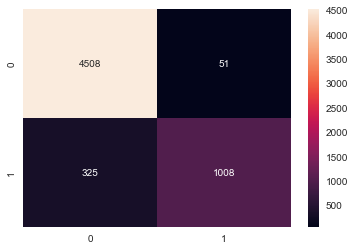

In [60]:
# Print the confusion matrix
print(confusion_matrix(y_test,preds_df_gbt2['pred_loan_status']))
sns.heatmap(confusion_matrix(y_test,preds_df_gbt2['pred_loan_status']), annot=True, fmt=".0f");

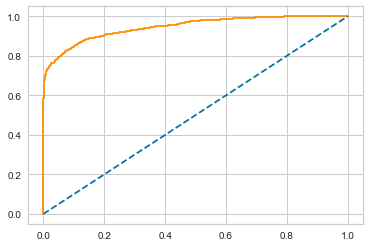

0.9457370374618221

In [85]:
# Plot the ROC curve of the probabilities of default
prob_default_xgb = preds_gbt2[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
auc

In [62]:
#economic impact for the non detected default
gbt_default_impact = economic_impact_nondetected_default(preds_df_gbt2, y_test,avg_loan_amnt)


Estimated Loss impact: $ 2474445.26


In [63]:
#cross validation within XGBoost
# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10
# Set any specific parameters for cross validation
params = {'objective': 'binary:logistic','seed': 99,'eval_metric':'auc'}

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train[selection_xgt2], label = y_train)

# Create the data frame of cross validations
cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,
            early_stopping_rounds=early_stopping)

# Print the cross validations data frame
print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.898912       0.002288       0.892372      0.008008
1        0.908842       0.003330       0.902955      0.011283
2        0.912021       0.002829       0.904931      0.010817
3        0.916412       0.001942       0.908561      0.009875
4        0.919933       0.002248       0.911476      0.010734


In [64]:
cv_results_big = xgb.cv(params, DTrain, num_boost_round = 600, nfold=10,
            shuffle = True)


0.94


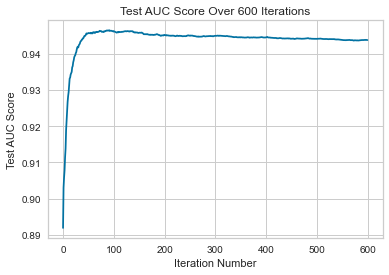

In [65]:
# Calculate the mean of the test AUC scores
print(np.mean(cv_results_big['test-auc-mean']).round(2))

# Plot the test AUC scores for each iteration
plt.plot(cv_results_big['test-auc-mean'])
plt.title('Test AUC Score Over 600 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

In [66]:
xgb_result = cross_validation(3,clf_gbt2, 'XGB', X_train[selection_xgt2], y_train, False)
xgb_result

,Model Name,PRECISION,RECALL,F1_score
0,XGB,0.94 +/- 0.002,0.734 +/- 0.006,0.824 +/- 0.004


## Unbalanced Data - Undersampling

In [67]:
#Undersampling training data

# Concat the training sets
X_y_train = pd.concat([X_train[selection_xgt2].reset_index(drop = True),y_train.reset_index(drop = True)], axis = 1)

# Get the counts of defaults and non-defaults
count_nondefault, count_default = X_y_train['loan_status'].value_counts()


# Separate nondefaults and defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

0    3801
1    3801
Name: loan_status, dtype: int64


In [68]:
# Train a model
clf_gbt_under= xgb.XGBClassifier().fit(X_y_train_under[selection_xgt2], np.ravel(X_y_train_under['loan_status']))

# predict
preds_gbt_under = clf_gbt_under.predict_proba(X_test[selection_xgt2])

preds_df_gbt_under= preds_df_func(preds_gbt_under,X_test[selection_xgt2], y_test, therehold = 0.5)
preds_df_gbt_under.head(1)

,prob_default,pred_loan_status
0,0.307373,0


In [69]:
print(classification_report(y_test, preds_df_gbt_under['pred_loan_status'], target_names=target_names))


              precision    recall  f1-score   support

 Non-Default       0.95      0.91      0.93      4559
     Default       0.73      0.84      0.78      1333

    accuracy                           0.89      5892
   macro avg       0.84      0.87      0.85      5892
weighted avg       0.90      0.89      0.89      5892



[[4137  422]
 [ 214 1119]]


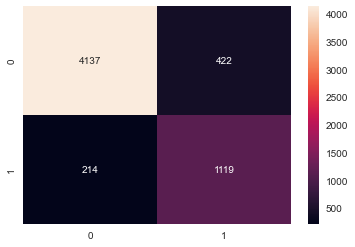

In [70]:
# Print the confusion matrix
print(confusion_matrix(y_test,preds_df_gbt_under['pred_loan_status']))
sns.heatmap(confusion_matrix(y_test,preds_df_gbt_under['pred_loan_status']), annot=True, fmt=".0f");

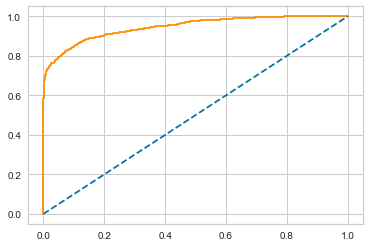

0.9457370374618221

In [71]:
# Plot the ROC curve of the probabilities of default
prob_default = preds_gbt_under[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
auc

In [72]:
#economic impact for the non detected default
xgb_uder_default_impact = economic_impact_nondetected_default(preds_df_gbt_under, y_test,avg_loan_amnt)

Estimated Loss impact: $ 2370909.31


In [73]:
xgb_under_result = cross_validation(3,clf_gbt_under, 'XGB -under_sampling', X_y_train_under[selection_xgt2], X_y_train_under['loan_status'], False)
xgb_under_result

,Model Name,PRECISION,RECALL,F1_score
0,XGB -under_sampling,0.887 +/- 0.006,0.821 +/- 0.011,0.853 +/- 0.005


In [77]:
modelling_result =pd.concat([lr_result, knn_result, xgb_result, xgb_under_result])
modelling_result.sort_values('RECALL', ascending=False)

,Model Name,PRECISION,RECALL,F1_score
0,XGB -under_sampling,0.887 +/- 0.006,0.821 +/- 0.011,0.853 +/- 0.005
0,XGB,0.94 +/- 0.002,0.734 +/- 0.006,0.824 +/- 0.004
0,KNN,0.666 +/- 0.009,0.45 +/- 0.006,0.537 +/- 0.004
0,Logistic Regression,0.742 +/- 0.021,0.151 +/- 0.001,0.251 +/- 0.001


In [78]:
impact_values ={'LR': [lr_default_impact], 'KNN': [knn_default_impact], 'XGB': [gbt_default_impact] , 'XGB under_sampling': xgb_uder_default_impact}
eco_impact = pd.DataFrame(impact_values)
print()
print('Financial Impact of non detection ')
eco_impact.apply(np.round).style.highlight_min(axis= 1)


Financial Impact of non detection 


,LR,KNN,XGB,XGB under_sampling
0,4108654.000000,3750329.000000,2474445.000000,2370909.000000


***Remarks:*** 
- The best result model is with XGB booster but are they stable? 
- With one would perfom better in real world?


## Tunning 

In [79]:
search_space = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'min_child_weight':range(1,6,2),
    'max_depth': range(3, 10),
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
  }


In [80]:
xgb_s = xgb.XGBClassifier()

rs_xgb = RandomizedSearchCV(estimator= xgb_s,
                            param_distributions=search_space,
                            n_iter=10,
                            cv=5,
                            verbose=True
               )

rs_xgb.fit(X_train[selection_xgt2], y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': range(3, 10),
                                        'min_child_weight': range(1, 6, 2),
                                        'n_estimators': [50, 100, 150, 200],
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   verbose=True)

In [81]:
rs_xgb.best_params_

{'subsample': 0.8,
 'reg_alpha': 0.1,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'colsample_bytree': 0.6}

In [82]:
y_pred_val = rs_xgb.predict(X_val[selection_xgt2])

#print(classification_report(y_test, preds_df_gbt_under['pred_loan_status'], target_names=target_names))

print(classification_report(y_val,y_pred_val) )

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4563
           1       0.97      0.69      0.81      1329

    accuracy                           0.93      5892
   macro avg       0.94      0.84      0.88      5892
weighted avg       0.93      0.93      0.92      5892



### Calibration Curve -Stability of the Model

In [83]:
# predict
preds_rs_gbt= rs_xgb.predict_proba(X_test[selection_xgt2])

preds_df_gbt_rs= preds_df_func(preds_rs_gbt,X_test[selection_xgt2], y_test, therehold = 0.5)
preds_df_gbt_rs.head(1)

# Plot the ROC curve of the probabilities of default
prob_default_rs = preds_rs_gbt[:, 1]


In [89]:
prob_default_xgb = preds_gbt2[:, 1]

preds_knn = knn_model.predict_proba(X_test[sel_columns_require_normalization])
prob_default_knn = preds_knn[:, 1]


ValueError: X has 12 features, but KNeighborsClassifier is expecting 28 features as input.

In [88]:
#Model calibration
#check the calibration of the  models to see how stable the default prediction performance is across probabilities.


calibration_xgb_under  = calibration_curve(y_test, prob_default,  n_bins = 30)
fraction_positiviry_under = calibration_xgb_under[0]
mean_prob_under = calibration_xgb_under[1]

calibration_xgb  = calibration_curve(y_test, prob_default_xgb,  n_bins = 30)
fraction_positiviry_xgb = calibration_xgb[0]
mean_prob_xgb = calibration_xgb[1]

calibration_rs_xgb  = calibration_curve(y_test, prob_default_rs,  n_bins = 30)
fraction_positiviry_xgb_rs = calibration_rs_xgb[0]
mean_prob_xgb_rs = calibration_rs_xgb[1]

calibration_knn  = calibration_curve(y_test, prob_default_knn,  n_bins = 30)
fraction_positiviry_knn = calibration_knn[0]
mean_prob_knn = calibration_knn[1]

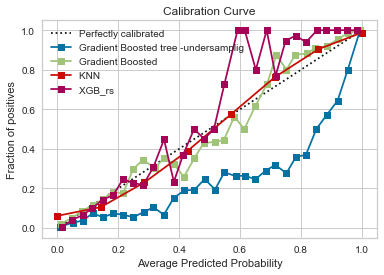

In [91]:
# Add the calibration curve for the gradient boosted tree
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_prob_under, fraction_positiviry_under,
         's-', label='%s' % 'Gradient Boosted tree -undersamplig')
plt.plot(mean_prob_xgb, fraction_positiviry_xgb,
         's-', label='%s' % 'Gradient Boosted ')
plt.plot(mean_prob_knn, fraction_positiviry_knn,
         's-', label='%s' % 'KNN ')
plt.plot(mean_prob_xgb_rs, fraction_positiviry_xgb_rs,
         's-', label='%s' % 'XGB_rs ')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

### Final Model « Validate
- Comparing model stability and performance, it was decided to use XGB Boost and not undersample the trainning data

In [94]:
# predict
preds_xgb_final_val= clf_gbt2.predict_proba(X_val[selection_xgt2])

preds_df_xgb_final_val =preds_df_func(preds_xgb_final_val,X_val[selection_xgt2], y_val, therehold = 0.82)
preds_df_xgb_final_val.head()


,prob_default,pred_loan_status
0,0.000996,0
1,0.010513,0
2,0.001239,0
3,0.062249,0
4,0.994938,1


In [95]:
print(classification_report(y_val, preds_df_xgb_final_val['pred_loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.91      1.00      0.95      4563
     Default       0.99      0.65      0.79      1329

    accuracy                           0.92      5892
   macro avg       0.95      0.82      0.87      5892
weighted avg       0.93      0.92      0.91      5892



[[4555    8]
 [ 463  866]]


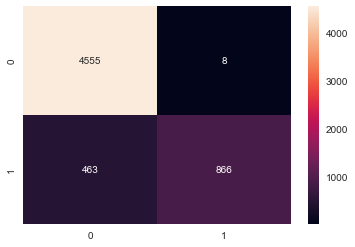

In [96]:
# Print the confusion matrix
print(confusion_matrix(y_val,preds_df_xgb_final_val['pred_loan_status']))
sns.heatmap(confusion_matrix(y_val,preds_df_xgb_final_val['pred_loan_status']), annot=True, fmt=".0f");

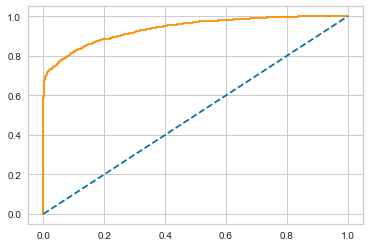

0.9370079649063268

In [98]:
# Plot the ROC curve of the probabilities of default
prob_default_final = preds_xgb_final_val[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_val, prob_default_final)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_val, prob_default_final)
auc

In [99]:
#economic impact for the non detected default
gbt_default_impact = economic_impact_nondetected_default(preds_df_xgb_final_val, y_val,avg_loan_amnt)

Estimated Loss impact: $ 2918072.79


In [100]:
# Store the number of loan defaults from the prediction data
num_defaults = preds_df_xgb_final_val['pred_loan_status'].value_counts()[1]
nondef_recalls = preds_df_xgb_final_val['pred_loan_status'].value_counts()[0]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_val,preds_df_xgb_final_val['pred_loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
non_detected_default_impact = round(avg_loan_amnt * num_defaults * (1 - default_recall), 2)
print('Estimated Loss impact: $', non_detected_default_impact)

Estimated Loss impact: $ 2918072.79


In [101]:
final_loss_pred = preds_df_xgb_final_val.copy() 

final_loss_pred = final_loss_pred.assign( y = y_val['loan_status'].values)

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print()
print('SUPPOSED REAL LOSS BASED ON THE VALIDATION df')
pd.crosstab(final_loss_pred['y'],
                 final_loss_pred['pred_loan_status']).apply(lambda x: x * avg_loan_amnt, axis = 0)


SUPPOSED REAL LOSS BASED ON THE VALIDATION df


pred_loan_status,0,1
y,,
0,"$43,653,298.00","$76,668.80"
1,"$4,437,206.80","$8,299,397.60"


In [102]:
pd.options.display.float_format = None


***Inferencies:***
   - Although the model estimated for a loss of approximately $ 2918072.79 based on the model metrics 
   
   -  When it was tested on the validation dataframe and compare the predictions versus the real data
    
      the loss was more smaller, only $76,668.80  for cases where default was not detected***
      
***Next steps***

    - Deploy

# Strategy Table 


In [103]:
#Making the strategy table
accept_rates = np.arange(1,0,-0.05)
thresholds = []
bad_rates = []

In [107]:
test_pred_df = preds_df_gbt2.drop(columns=['pred_loan_status']).copy()
test_pred_df['true_loan_status'] = y_test.reset_index(drop=True)
test_pred_df['loan_amnt'] = X_test.loan_amnt.reset_index(drop=True)

test_pred_df['loss_given_default'] = 1


In [108]:
# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(preds_df_gbt2['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(preds_df_gbt2['prob_default'], rate).round(3))
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))

In [110]:
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
strat_df

,Acceptance Rate,Threshold,Bad Rate
0,1.00,1.000,0.226
1,0.95,1.000,0.189
2,0.90,1.000,0.140
3,0.85,0.998,0.090
4,0.80,0.990,0.060
5,0.75,0.890,0.048
6,0.70,0.344,0.039
7,0.65,0.192,0.034
8,0.60,0.133,0.029
9,0.55,0.095,0.026


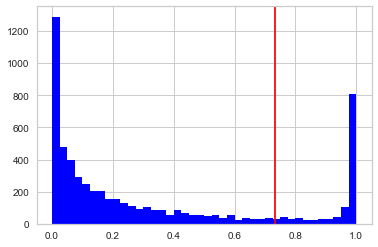

In [111]:
# Plot the predicted probabilities of default
plt.hist(prob_default, color = 'blue', bins = 40)

# Calculate the threshold with quantile
threshold = np.quantile(prob_default, 0.80)


# Add a reference line to the plot for the threshold
plt.axvline(x = threshold, color = 'red')
plt.show()

In [112]:
# Calculate the threshold for a 85% acceptance rate
threshold_80 = np.quantile(test_pred_df['prob_default'], 0.8)

# Apply acceptance rate threshold
test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > threshold_80 else 0)

# Print the counts of loan status after the threshold
test_pred_df['pred_loan_status'].value_counts()

0    4713
1    1179
Name: pred_loan_status, dtype: int64

In [113]:
# Calculate the bank's expected loss and assign it to a new column
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loss_given_default'] * test_pred_df['loan_amnt']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_pred_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))



Total expected loss:  $13,937,350.54


In [114]:
#Bad rates
# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Calculate the bad rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

0.06025885847655421


In [115]:
# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
pd.crosstab(test_pred_df['true_loan_status'],
                 test_pred_df['pred_loan_status']).apply(lambda x: x * avg_loan_amnt, axis = 0)

pred_loan_status,0,1
true_loan_status,,
0,"$42,445,764.40","$1,245,868.00"
1,"$2,721,742.40","$10,053,196.40"


In [116]:
pd.options.display.float_format = None


In [117]:
final_loss_pred = preds_df_xgb_final_val.copy() 

final_loss_pred = final_loss_pred.assign( y = y_val['loan_status'].values)
final_loss_pred.head()

,prob_default,pred_loan_status,y
0,0.000996,0,0
1,0.010513,0,0
2,0.001239,0,0
3,0.062249,0,1
4,0.994938,1,1


In [118]:
# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
pd.crosstab(final_loss_pred['y'],
                 final_loss_pred['pred_loan_status']).apply(lambda x: x * avg_loan_amnt, axis = 0)

pred_loan_status,0,1
y,,
0,"$43,653,298.00","$76,668.80"
1,"$4,437,206.80","$8,299,397.60"
